Mega-Amp Spherical Tokamak
==========================

An example of a dead start (from scratch) for the MAST tokamak


In [26]:
from freegs import machine
from freegs.equilibrium import Equilibrium

# Define the poloidal field coil set
tokamak = machine.MAST()

# Define the domain to solve over
eq = Equilibrium(tokamak=tokamak,
                 Rmin=0.2, Rmax=2.0,    # Radial domain
                 Zmin=-2.0, Zmax=2.0,   # Height range
                 nx=129, ny=129)        # Number of grid points

Define toroidal current function. The RHS of the Grad-Shafranov equation is determined by the toroidal current density

$j_{tor} = -R\frac{\partial p}{\partial \psi} - \frac{1}{\mu_0 R}f\frac{\partial p}{\partial \psi}$

The profiles can be adjusted to match global constrants, such as the pressure on axis and the total plasma current $I_p$

The toroidal current function jtor_func calculates the toroidal current density $j_{tor}$ given $\psi$ on an R-Z mesh

In [27]:
from freegs.jtor import ConstrainPaxisIp

jtor_func = ConstrainPaxisIp(1e4, # Plasma pressure on axis [Pascals]
                             1e6) # Plasma current [Amps]

In [28]:
from freegs import constraints

xpoints = [(0.6, -1.1),   # (R,Z) locations of X-points
           (0.6, 1.1)]

isoflux = [(0.6,-1.1, 1.4, 0.0),(0.6,1.1, 1.4, 0.0), (0.6,-1.1, 0.25, 0.0)]

constrain = lambda eq : constraints.xpointConstrain(eq, xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

Current changes: [ 4559240.  4559848. -2851956. -2851912.   537200.   536752. -1048928.
 -1048576.    74848.    74976.]


In [29]:
from freegs import picard

picard.solve(eq,           # The equilibrium to adjust
             jtor_func,    # The toroidal current profile function
             constrain,    # Constraint function to set coil currents
             niter=5, sublevels=5, ncycle=3)    # Linear solve settings

Current changes: [ 497.89233398   11.92749023  -39.95092773    2.26196289   17.55371094
  -53.82861328   44.33789062   85.54296875  -66.47460938  -50.02441406]
Constraints: L = 8.519552e+05, Beta0 = 2.347541e-02
Starting max residual:  1119.02568487
Cycle  0 :  29.4879510148
Cycle  1 :  6.25638817972
Cycle  2 :  2.01832837249
Maximum change in psi: 6.948669e-01. Relative: 1.550906e-01
Current changes: [-4243338. -4243862.  2829582.  2829530.  -641328.  -640784.   882656.
   882256.  -267936.  -268112.]
Constraints: L = 1.198074e+06, Beta0 = 1.669346e-02
Starting max residual:  14.0339532971
Cycle  0 :  1.14978235857
Cycle  1 :  0.742853746185
Cycle  2 :  0.518400075993
Maximum change in psi: 2.664256e-02. Relative: 5.418074e-02
Current changes: [-37745.25    -37270.1875  -45456.03125 -45491.03125  64415.875    64438.1875
 -69064.25    -69119.75     81087.75     81040.1875 ]
Constraints: L = 1.353616e+06, Beta0 = 1.477523e-02
Starting max residual:  9.22262708797
Cycle  0 :  0.373561798

In [30]:
print("Plasma current: %e Amps" % (eq.plasmaCurrent()))

Plasma current: 1.000000e+06 Amps


In [31]:
tokamak.printCurrents()

P2U : (0.50,1.60)  2.598441e+05
P2L : (0.50,-1.60)  2.598351e+05
P3U : (1.10,1.10)  -1.039112e+05
P3L : (1.10,-1.10)  -1.039157e+05
P4U : (1.50,1.10)  7.539444e+03
P4L : (1.50,-1.10)  7.591804e+03
P5U : (1.60,0.50)  -2.886886e+05
P5L : (1.60,-0.50)  -2.887030e+05
P6U : (1.50,0.90)  -5.414156e+04
P6L : (1.50,-0.90)  -5.417906e+04


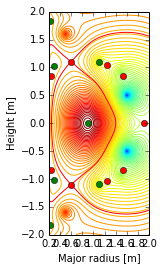

In [32]:
%matplotlib inline

from freegs.plotting import plotEquilibrium
import matplotlib.pyplot as plt

psi = eq.psi()

ax = plotEquilibrium(eq.R, eq.Z, psi)

from freegs.critical import find_critical
opt, xpt = find_critical(eq.R, eq.Z, psi)
psi_bndry = xpt[0][2]

for r,z,_ in xpt:
    ax.plot(r,z,'ro')
for r,z,_ in opt:
    ax.plot(r,z,'go')
psi_bndry = xpt[0][2]
sep_contour=ax.contour(eq.R, eq.Z,psi, levels=[psi_bndry], colors='r')

Modifying the equilibrium
-------------------------

Modify the constraints for the X-point locations and isoflux pairs. Starting from the previous solution, this quie quickly finds a new solution.

Current changes: [ 362980.     362891.875  273714.625  273724.75  -179680.5   -179736.25
  233961.     234007.5   -503241.    -503222.5  ]


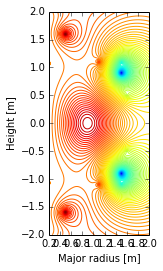

In [33]:
xpoints = [(0.7, -1.0),   # (R,Z) locations of X-points
           (0.7, 1.0)]

isoflux = [(0.7,-1.0, 1.4, 0.0),(0.7,1.0, 1.4, 0.0), (0.7,-1.0, 0.3, 0.0)]

constrain = lambda eq : constraints.xpointConstrain(eq, xpoints, gamma=1e-12, isoflux=isoflux)

constrain(eq)

plotEquilibrium(eq.R, eq.Z, eq.psi())

In [34]:
picard.solve(eq,           # The equilibrium to adjust
             jtor_func,    # The toroidal current profile function
             constrain,    # Constraint function to set coil currents
             niter=5, sublevels=5, ncycle=3)    # Linear solve settings

Current changes: [-53.93460083  37.52246857   2.59493256  -3.53076172 -11.11213684
   8.45581055   6.62594604  -5.83331299   4.1149292   -0.74676514]
Constraints: L = 1.610168e+06, Beta0 = 1.242106e-02
Starting max residual:  4.07331388551
Cycle  0 :  0.0851138171067
Cycle  1 :  0.0359377261583
Cycle  2 :  0.0327244404936
Maximum change in psi: 1.022113e-02. Relative: 9.946643e-03
Current changes: [-11677.7890625 -11670.        -33684.765625  -33685.9765625  31087.5
  31095.109375  -42095.3125    -42101.65625    61099.4375     61095.34375  ]
Constraints: L = 1.660070e+06, Beta0 = 1.204769e-02
Starting max residual:  1.88914210674
Cycle  0 :  0.0303120550979
Cycle  1 :  0.0278521770357
Cycle  2 :  0.0256991484008
Maximum change in psi: 2.493869e-03. Relative: 2.655611e-03
Current changes: [ -1229.16601562  -1233.05664062  -6747.92578125  -6747.953125
   6184.4609375    6184.7109375   -8683.40625     -8683.234375
  11682.0859375   11681.921875  ]
Constraints: L = 1.678606e+06, Beta0 = 1.

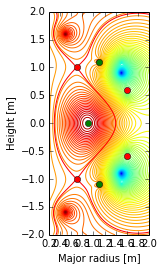

In [35]:
psi = eq.psi()

ax = plotEquilibrium(eq.R, eq.Z, psi)

opt, xpt = find_critical(eq.R, eq.Z, psi)
psi_bndry = xpt[0][2]

for r,z,_ in xpt:
    ax.plot(r,z,'ro')
for r,z,_ in opt:
    ax.plot(r,z,'go')
psi_bndry = xpt[0][2]
sep_contour=ax.contour(eq.R, eq.Z,psi, levels=[psi_bndry], colors='r')